# Pitch & Roll sequence prediction

In [1]:
import gc
import os
import sys
import json
import math
import pickle
import random
import platform
import numpy as np
import pandas as pd
import multiprocessing
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

In [2]:
print(torch.__version__)
print(pl.__version__)

1.11.0
1.6.1


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)
cpu_count = multiprocessing.cpu_count()
print('CPU count:', cpu_count)
platform_os = "windows" if platform.system() == "Windows" else "linux"
print("Platform:", platform_os)

# Pytorch Dataloader can't handle n_workers > 0 on windows due to bugs
N_WORKERS = 0 if platform_os=="windows" else cpu_count
print(f"number of workers: {N_WORKERS}")

device: cuda
CPU count: 16
Platform: windows
number of workers: 0


# Constants

In [4]:
# change to appropriate location
TRAIN_FOLDER = "../../3dmodel/test_4_episode_"
MODEL_NAME = "test_LSTM_PR_sequence_output"
MODEL_STATE_FOLDER = f"../model_states/{MODEL_NAME}"
RESULT_FOLDER = f"../../results/{MODEL_NAME}"
TRAIN_RESULT_FOLDER = f"../training_results/{MODEL_NAME}"
TEST_RESULT_FOLDER = f"../test_results/{MODEL_NAME}"
SAVE_RESULTS = True
TRAIN_MODEL = True

In [5]:
if not os.path.exists(MODEL_STATE_FOLDER):
    os.mkdir(MODEL_STATE_FOLDER)
if not os.path.exists(TRAIN_RESULT_FOLDER):
    os.mkdir(TRAIN_RESULT_FOLDER)
if not os.path.exists(TEST_RESULT_FOLDER):
    os.mkdir(TEST_RESULT_FOLDER)
if not os.path.exists(RESULT_FOLDER):
    os.mkdir(RESULT_FOLDER)

In [6]:
FRAMES_IN = 60
FRAMES_OUT = 60

N_EPISODES = 540
FRAMES_PER_EPISODE = 400

TRAIN_SIZE = 0.8
NUM_EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

CUDA = device.type == 'cuda'
DEVICE = device

# Load data from episodes

In [7]:
# view first episode 
filename = TRAIN_FOLDER + "1/labels_0.json"
data = []
labels = json.load(open(filename))
ep1 = pd.DataFrame(labels)
ep1 = ep1.transpose()
ep1.rename(columns = {0:'pitch', 1:'roll'}, inplace=True)
ep1.head()

,pitch,roll
0,15.915869,2.358416
1,14.295925,1.700391
2,6.213590,1.611325
3,1.235337,6.175461
4,1.341678,3.695468


In [8]:
# load all data
episodes = [] # holds pitch, roll, episode number and position within episode number
pr_per_episode = [] # holds all pitch and roll tuples per episode in one row (see pr_per_episode_df)
for ep in range(1, N_EPISODES+1):
    filename = TRAIN_FOLDER+ str(ep) +"/labels_0.json"
    labels = json.load(open(filename))
    pr_in_current_episode = []
    for i in labels:
        pr_in_current_episode.append(labels[i])
        episodes.append(labels[i]+[ep, i])
    pr_per_episode.append(pr_in_current_episode)

In [9]:
p_r_df = pd.DataFrame(episodes)
# p_r_df.rename(columns = {0:'pitch', 1:'roll', 2:'episode', 3:'position_within_episode'}, inplace=True)
p_r_df.rename(columns = {0:'pitch', 1:'roll'}, inplace=True)
p_r_df = p_r_df.astype({"pitch": float, "roll": float})
p_r_df = p_r_df.drop([2,3], axis=1)     # drop episode and position_within_episode
p_r_df.head()

,pitch,roll
0,15.915869,2.358416
1,14.295925,1.700391
2,6.213590,1.611325
3,1.235337,6.175461
4,1.341678,3.695468


In [10]:
pr_per_episode_df = pd.DataFrame(pr_per_episode)
pr_per_episode_df.head()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
0,"[15.9158690209565, 2.3584162956378014]","[14.29592488097425, 1.7003911752437184]","[6.2135895738216185, 1.6113252950233405]","[1.235337361757596, 6.175460896553669]","[1.341678284492817, 3.695467874019875]","[-0.0651516203579112, 3.0756651325514186]","[-4.392773839217525, 0.8726621608752939]","[-4.184235784139164, 0.35570707390756684]","[-3.3195511241318867, 6.666652243167843]","[5.894038319728926, -0.13849362470644613]",...,"[10.389031062517569, 1.5248242575580084]","[-1.2002740520448067, 0.5092731518638726]","[-10.535511299457662, -4.131095631735996]","[-18.896939235154417, -4.945806145463817]","[-22.184256348715486, -1.9589200251876364]","[-0.2044812962373426, 1.503336589150854]","[1.0747428590627885, 10.724272114907427]","[13.3735940647023, 1.5429493384594009]","[11.19363673825518, -0.8486316877453378]","[5.131548017300437, 0.9777773314587621]"
1,"[15.97866748773289, 2.268047343389832]","[9.855846859112509, 1.360887657924949]","[6.105283691039549, 1.5623034265245723]","[1.3507750292502163, 4.69679068181667]","[1.724415511875592, 4.076017413155836]","[0.03351754252109094, 3.1310278711991915]","[-7.604052164296134, 1.8397739918625224]","[-2.5471177738191515, 2.5391520656996245]","[-2.625542432756061, 7.979014181804202]","[6.084213411223707, 0.050736486104279443]",...,"[9.820045568804241, 1.8697905388306129]","[1.4623980360913844, 0.5153293418627053]","[-10.619933291372666, -3.1525508644909594]","[-15.18629041193054, -5.8295536500011895]","[-21.331025702502906, -4.46392562734884]","[-0.980658924236567, 0.000323666141662183]","[1.1033292284517018, 11.141469460921915]","[14.080388870204388, 0.990625450896085]","[11.345563197284712, -0.7964093420118897]","[4.760598735929752, 1.6810054975536355]"
2,"[15.961578354429518, 2.074803789410423]","[6.179635849683839, 0.12110205542910284]","[6.079602606647125, 1.6753055979695541]","[1.3610495547526196, 8.341244726699365]","[0.2675885889498374, 4.800268474629186]","[0.06658679384694029, 3.1533924718627517]","[-5.6663031642145985, 1.2498673085563288]","[-6.884764942802091, 0.6056172923359865]","[-2.0016676178818074, 6.428251747264541]","[6.3722296819184505, 0.18303076698380022]",...,"[9.64882211782213, 1.973062358750971]","[2.395990446922511, 0.4464584900686305]","[-10.690737593629956, -2.750964556154771]","[-14.010888280304924, -6.054184484537745]","[-21.49614211059338, -4.60819715186608]","[-4.0433481914688425, 1.2884030224101293]","[1.1818524982447534, 11.202268389818784]","[14.342162700334297, 0.7591126138013591]","[8.761085355922647, -0.30987522391631195]","[4.628031167442151, 1.9668671637303579]"
3,"[7.69906521829289, 1.5796155014713218]","[8.481780991514256, 0.05603940762328032]","[3.159275826059072, 0.8631695853111513]","[1.049441063612711, 2.2469629763088257]","[0.3593771266476851, 1.8488201505313813]","[-0.07217797069325685, 1.49066178576372]","[-2.60443416001296, 0.27787303957087833]","[-5.056486372756112, 0.3636566403690948]","[-1.834612289840697, 3.3018218740372376]","[2.911777518181313, -0.18950627990486155]",...,"[5.454093028683711, 0.6530340130189489]","[-1.6791362668768735, 0.18489125982090143]","[-5.466481284290821, -2.2171972253493215]","[-11.403407215591903, -1.6377460675585367]","[-9.300110224841715, 0.5591612804484688]","[-0.9304575674455022, 1.7758436346746147]","[0.5600581696638561, 4.948483152731639]","[6.361704787294284, 1.072871920838734]","[6.398844794679874, -0.44728280852408636]","[2.689249101248651, 0.22945817745416852]"
4,"[7.810402424405974, 1.4887826299683204]","[7.868472692729423, 0.18104613012244872]","[3.1332145989506532, 0.9057401800562839]","[0.9454851575582939, 2.1807891154219803]","[0.49654637500602317, 1.7821752200352163]","[-0.04738833270922448, 1.498974979757272]","[-2.617495189253317, 0.3204662326372101]","[-4.8539576034868945, 0.6764536111050119]","[-1.7194979891165945, 3.217247483526378]","[2.9227715614240943, -0.18400777751980293]",...,"[5.2915481868157475, 0.7305929454785594

In [11]:
# Function to normalize pitch and roll angles
def norm_pr(x, min = -90.0, max = 90.0):
    return ((x - min) * 2) / (max - min) - 1

# Function to normalize pitch and roll angles
def denorm_pr(x, min = -90.0, max = 90.0):
    return ((x + 1) * (max - min))/2 + min

In [12]:
# check if the norm and denorm functions work properly
# compares norm and denorm values for all values within [-90, 90] interval
a = np.arange(-90,91)
n = norm_pr(a)
np.unique(a == np.rint(denorm_pr(n)))

array([ True])

In [13]:
# normalize PR-values
p_r_df['pitch'] = p_r_df['pitch'].apply(lambda x : norm_pr(x))
p_r_df['roll'] = p_r_df['roll'].apply(lambda x : norm_pr(x))
p_r_df.head()

,pitch,roll
0,0.176843,0.026205
1,0.158844,0.018893
2,0.069040,0.017904
3,0.013726,0.068616
4,0.014908,0.041061


# Create input and output sequences

In [14]:
# function to create sequences with one target column
def create_sequences(input_data: pd.DataFrame, 
        input_feature_columns, 
        output_feature_columns,
        input_sequence_length=FRAMES_IN, 
        output_sequence_length=FRAMES_OUT, 
        episode_length = FRAMES_PER_EPISODE, 
        n_episodes = N_EPISODES
    ):
    sequences= []

    # make sequences per episode, one sequence can only hold data of one and the same episode!
    for n in tqdm(range(n_episodes)):
        for l in range(episode_length-output_sequence_length-input_sequence_length+1):

            i = l+(n*episode_length)

            # sequence = input_data.iloc[i:i+input_sequence_length][input_feature_columns]
            sequence = input_data.iloc[i:i+input_sequence_length].transpose()

            target_position = i + input_sequence_length
            # target = input_data.iloc[target_position:target_position+output_sequence_length][output_feature_columns]
            target = input_data.iloc[target_position:target_position+output_sequence_length].transpose()

            sequences.append((sequence, target))

    return sequences

In [15]:
input_features = ["pitch", "roll"]
output_features = ["pitch", "roll"]
all_sequences = create_sequences(p_r_df, output_features, input_features)

  0%|          | 0/540 [00:00<?, ?it/s]

In [16]:
len(all_sequences), all_sequences[0][0].shape, all_sequences[0][1].shape 

(151740, (2, 60), (2, 60))

In [17]:
all_sequences[0][0]

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
pitch,0.176843,0.158844,0.069040,0.013726,0.014908,-0.000724,-0.048809,-0.046492,-0.036884,0.065489,...,0.164457,0.253773,0.209255,0.126102,-0.008498,0.197257,0.015589,0.024246,0.058990,0.104660
roll,0.026205,0.018893,0.017904,0.068616,0.041061,0.034174,0.009696,0.003952,0.074074,-0.001539,...,0.133329,0.165900,0.179920,0.163708,0.131590,0.006408,-0.022288,-0.008416,0.044812,0.018803


In [18]:
# Grab random subsets from all sequences for training and test data (without overlapping data)
data_size = len(all_sequences)
data_indices = list(np.arange(0, data_size, 1))

# train indices are random sample from all data indices
random.seed(42)
train_size = int(TRAIN_SIZE * data_size)
train_indices = random.sample(data_indices, train_size)

# test indices are the difference of all data indices and train indices
test_indices = list(set(data_indices) - set(train_indices))

print((len(train_indices) + len(test_indices)) <= data_size)
print("Training size:", len(train_indices),"| Test size:", len(test_indices))
print(train_indices[:10])
print(test_indices[:10])

True
Training size: 121392 | Test size: 30348
[29184, 6556, 72097, 64196, 58513, 36579, 26868, 142964, 22790, 110604]
[1, 131073, 3, 131075, 14, 131088, 131089, 18, 21, 26]


In [19]:
train_sequences = []
test_sequences = []

for idx in tqdm(train_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    train_sequences.append((seq,label))

for idx in tqdm(test_indices):
    seq = all_sequences[idx][0]
    label = all_sequences[idx][1]
    test_sequences.append((seq,label))

print((len(train_sequences) + len(test_sequences)) <= len(all_sequences))
print(len(train_sequences), train_sequences[0][0].shape, train_sequences[0][1].shape) 
print(len(test_sequences), test_sequences[0][0].shape, test_sequences[0][1].shape)

  0%|          | 0/121392 [00:00<?, ?it/s]

  0%|          | 0/30348 [00:00<?, ?it/s]

True
121392 (2, 60) (2, 60)
30348 (2, 60) (2, 60)


## Pytorch Dataset and DataLoader

In [20]:
class PRDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence, labels = self.sequences[index]

        return dict(
            sequence = torch.Tensor(sequence.to_numpy()),
            labels = torch.Tensor(labels.to_numpy())
        )

In [21]:
class PRDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batchsize = BATCH_SIZE):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batchsize = batchsize

    # turns normal list object into Dataset object
    def setup(self):
        self.train_dataset = PRDataset(self.train_sequences)
        self.test_dataset = PRDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=N_WORKERS,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers=N_WORKERS,
        )

In [22]:
# setup datamodule
data_module = PRDataModule(train_sequences, test_sequences, BATCH_SIZE)
data_module.setup()

In [23]:
# check if shape of train dataloader object is correct
for batch in data_module.train_dataloader():
    x_train = batch["sequence"]
    y_train = batch["labels"]
    break

print(x_train.shape, y_train.shape)

torch.Size([64, 2, 60]) torch.Size([64, 2, 60])


In [24]:
# check if shape of val dataloader object is correct
for batch in data_module.val_dataloader():
    x_val = batch["sequence"]
    y_val = batch["labels"]
    break

print(x_val.shape, y_val.shape)

torch.Size([64, 2, 60]) torch.Size([64, 2, 60])


In [25]:
# check if shape of test dataloader object is correct
for batch in data_module.test_dataloader():
    x_test = batch["sequence"]
    y_test = batch["labels"]
    break

print(x_test.shape, y_test.shape)

torch.Size([1, 2, 60]) torch.Size([1, 2, 60])


## LSTM Model

In [26]:
# ENCODER
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size=300, num_layers=1):
        super(Encoder, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.input_size = input_size

        self.encoder_lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=True,
        )

    def forward(self, input_seq):
        ouputs, hidden = self.encoder_lstm(input_seq)
        
        return ouputs, hidden

In [27]:
# DECODER
class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size=300, num_layers = 1):
        super(Decoder, self).__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.decoder_lstm = nn.LSTM(
            input_size = hidden_size, 
            hidden_size = hidden_size,
            num_layers = num_layers, 
            batch_first = True
        )

        self.decoder_fc_1 = nn.Linear(hidden_size, int(hidden_size/2))
        self.decoder_fc_2 = nn.Linear(int(hidden_size/2), output_size)

        #self.linear = nn.Linear(hidden_size, output_size)           

    def forward(self, x_input, hidden):

        outputs, hidden = self.decoder_lstm(x_input, hidden)
        
        outputs = self.decoder_fc_1(outputs)
        outputs = self.decoder_fc_2(outputs)

        return outputs, hidden

In [28]:
# Wrapper class for encoder and decoder
class LSTM_seq2seq(nn.Module):    
    def __init__(self, input_size, output_size, hidden_size = 300):
        super(LSTM_seq2seq, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = Decoder(output_size = output_size, hidden_size = hidden_size)

    def forward(self, input_tensor):
        encoder_outputs, encoder_hidden  = self.encoder.forward(input_tensor)

        decoder_outputs, decoder_hidden = self.decoder.forward(encoder_outputs, encoder_hidden)

        return decoder_outputs
                

# Training

In [29]:
# get the first batch out of the dataloader for testing purposes
for batch in data_module.train_dataloader():
    x_train = batch["sequence"]
    y_train = batch["labels"]
    break

print(x_train.shape, y_train.shape)

torch.Size([64, 2, 60]) torch.Size([64, 2, 60])


In [30]:
lstm_seq2seq = LSTM_seq2seq(input_size=FRAMES_IN, output_size=FRAMES_OUT)

outputs = lstm_seq2seq.forward(x_train)
# output should be a sequence of pitch and roll (2 features)
outputs.shape

torch.Size([64, 2, 60])

### Training loop

In [36]:
model = LSTM_seq2seq(input_size=FRAMES_IN, output_size=FRAMES_OUT)

if CUDA:
    model.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# TRACKERS
train_losses_epoch = []
val_losses_epoch = []

n_epochs = NUM_EPOCHS

for epoch in tqdm(range(NUM_EPOCHS)):

    # validation loss with initial weights
    with torch.no_grad():
        i = 0
        total_batch_loss = 0
        for batch in data_module.val_dataloader():
            x_val = batch["sequence"]
            y_val = batch["labels"]
            i += 1

            if CUDA: 
                x_val = batch["sequence"].cuda()
                y_val = batch["labels"].cuda()
            
            # Predict on forward pass 
            y_pred = model.forward(x_val)

            loss = criterion(y_pred, y_val)
            total_batch_loss += loss.item()

        mean_val_loss = total_batch_loss/i
        val_losses_epoch.append(mean_val_loss)
        val_loss = round(mean_val_loss, 6)


    i = 0 
    total_batch_loss = 0

    for batch in data_module.train_dataloader():
        print(f"batch {i}", end='\r')
        i += 1
        x_train = batch["sequence"]
        y_train = batch["labels"]

        if CUDA: 
            x_train = batch["sequence"].cuda()
            y_train = batch["labels"].cuda()
        
        # Predict on forward pass 
        y_pred = model.forward(x_train)

        # Calculate loss/error
        loss = criterion(y_pred, y_train)
        total_batch_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    mean_train_loss = total_batch_loss/i
    train_losses_epoch.append(mean_train_loss)
    train_loss = round(mean_train_loss, 6)

    print(f"EPOCH {epoch} training loss: {train_loss} | validation loss: {val_loss}")

  0%|          | 0/50 [00:00<?, ?it/s]

EPOCH 0 training loss: 0.005536 | validation loss: 0.00923
EPOCH 1 training loss: 0.004113 | validation loss: 0.005155
EPOCH 2 training loss: 0.00237 | validation loss: 0.003017
EPOCH 3 training loss: 0.001737 | validation loss: 0.001981
EPOCH 4 training loss: 0.001473 | validation loss: 0.001622
EPOCH 5 training loss: 0.001311 | validation loss: 0.001431
EPOCH 6 training loss: 0.001192 | validation loss: 0.001299
EPOCH 7 training loss: 0.001103 | validation loss: 0.001202
EPOCH 8 training loss: 0.001034 | validation loss: 0.001129
EPOCH 9 training loss: 0.00098 | validation loss: 0.001071
EPOCH 10 training loss: 0.000937 | validation loss: 0.001026
EPOCH 11 training loss: 0.000901 | validation loss: 0.00099
EPOCH 12 training loss: 0.000872 | validation loss: 0.000961
EPOCH 13 training loss: 0.000845 | validation loss: 0.000936
EPOCH 14 training loss: 0.000822 | validation loss: 0.000915
EPOCH 15 training loss: 0.000801 | validation loss: 0.000896
EPOCH 16 training loss: 0.000782 | val

### Save model state and training losses

In [37]:
# save train losses per epoch
filename = f'{TRAIN_RESULT_FOLDER}/train_loss_{FRAMES_IN}in_{FRAMES_OUT}out_{NUM_EPOCHS}epochs'
with open(filename, 'wb') as f: 
    pickle.dump(train_losses_epoch, f)
# save val losses per epoch
filename = f'{TRAIN_RESULT_FOLDER}/val_loss_{FRAMES_IN}in_{FRAMES_OUT}out_{NUM_EPOCHS}epochs'
with open(filename, 'wb') as f: 
    pickle.dump(val_losses_epoch, f)

In [38]:
filename = f'{MODEL_STATE_FOLDER}/{MODEL_NAME}_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}'
torch.save(model.state_dict(), filename)

### Load model state

In [31]:
filename = f'{MODEL_STATE_FOLDER}/{MODEL_NAME}_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}'
loaded_model = LSTM_seq2seq(input_size=FRAMES_IN, output_size=FRAMES_OUT)
loaded_model.load_state_dict(torch.load(filename))
if CUDA: 
    loaded_model = loaded_model.cuda()


loaded_model.eval()

LSTM_seq2seq(
  (encoder): Encoder(
    (encoder_lstm): LSTM(60, 300, batch_first=True)
  )
  (decoder): Decoder(
    (decoder_lstm): LSTM(300, 300, batch_first=True)
    (decoder_fc_1): Linear(in_features=300, out_features=150, bias=True)
    (decoder_fc_2): Linear(in_features=150, out_features=60, bias=True)
  )
)

## Training results

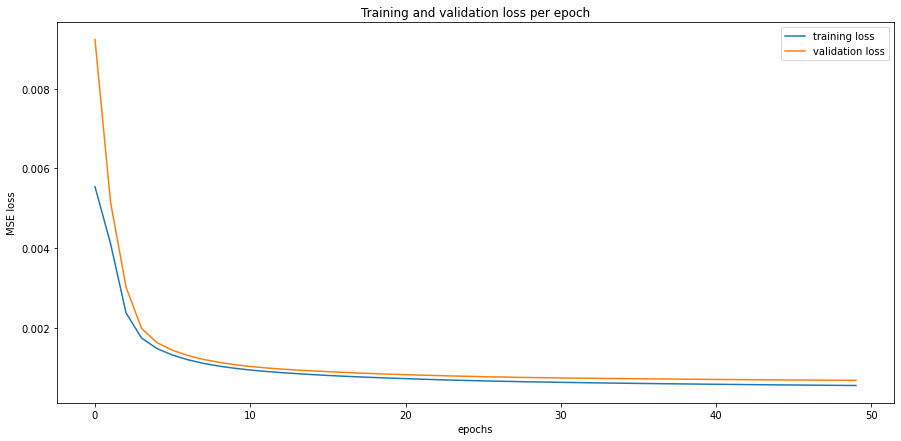

In [40]:
plt.figure(figsize=(15, 7))
plt.plot(range(NUM_EPOCHS), train_losses_epoch, label='training loss')
plt.plot(range(NUM_EPOCHS), val_losses_epoch, label='validation loss')
plt.xlabel("epochs")
plt.ylabel("MSE loss")
plt.title("Training and validation loss per epoch")
plt.legend()
if SAVE_RESULTS:
    plt.savefig(f'{RESULT_FOLDER}/train-test-loss_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

# Testing

In [33]:
# get first I/O-sequence of test dataset for visualizing a prediction
for batch in data_module.test_dataloader():
    x_test = batch["sequence"]
    y_test = batch["labels"]
    break

if CUDA:
    x_test = x_test.cuda()
    y_test = y_test.cuda()

# batch size = 1 for testing dataset
print(x_test.shape, y_test.shape)

torch.Size([1, 2, 60]) torch.Size([1, 2, 60])


In [38]:
criterion = nn.MSELoss()

# make one prediction for visualization
with torch.no_grad():
    y_pred = loaded_model(x_test)
    loss = criterion(y_pred, y_test)

    # clean up tensor and round results to visually compare predicted sequence
    a = y_pred.squeeze(0)[0].tolist()
    a = [round(num, 4) for num in a]

    b = y_test.squeeze(0)[0].tolist()
    b = [round(num, 4) for num in b]

    print(f'predicted pitch: {a}\nreal pitch:\t {b}')
    print("loss:", round(loss.item(), 6))

# squeeze out batch size and convert into cpu format for plotting
x_test.squeeze(0).shape
input_sequence = x_test.squeeze(0).cpu()
output_sequence = y_test.squeeze(0).cpu()
predicted_sequence = y_pred.squeeze(0).cpu()
input_sequence.shape, output_sequence.shape, predicted_sequence.shape

predicted pitch: [-0.012, -0.0975, -0.0592, 0.0727, 0.1336, 0.1147, 0.0361, -0.0101, -0.015, -0.0423, -0.0726, -0.0704, -0.0142, -0.033, -0.0963, -0.1551, -0.116, 0.0217, 0.1308, 0.1174, 0.0513, 0.0188, -0.0486, -0.0942, -0.1263, -0.1137, -0.0741, -0.0139, 0.0447, 0.003, -0.0706, -0.1272, -0.1434, -0.1646, -0.1777, -0.1781, -0.2293, -0.2854, -0.2349, -0.0811, 0.0676, 0.0942, 0.0484, -0.0246, -0.0423, 0.0475, 0.1246, 0.084, -0.0096, 0.0087, 0.0935, 0.1048, 0.022, -0.0119, -0.0722, -0.1213, -0.1324, -0.0805, 0.0034, 0.0771]
real pitch:	 [0.0331, -0.1455, 0.0176, 0.0285, 0.1294, 0.1163, 0.0226, 0.0171, -0.066, 0.0246, -0.1826, 0.0472, -0.0261, -0.0216, -0.0763, -0.1334, -0.1328, 0.0595, 0.1207, 0.0719, 0.0458, 0.0467, -0.0678, -0.1164, -0.1001, -0.1657, -0.0252, -0.0029, 0.0356, 0.0671, -0.1383, -0.0755, -0.1706, -0.2211, -0.1376, -0.1707, -0.2143, -0.3415, -0.2161, 0.0278, -0.0169, 0.0968, 0.1484, -0.1321, 0.0199, 0.0271, 0.1534, 0.057, -0.081, 0.0942, 0.0339, 0.1032, 0.041, -0.0571, -0.

(torch.Size([2, 60]), torch.Size([2, 60]), torch.Size([2, 60]))

### Prediction vs. real on first test I/O-sequence

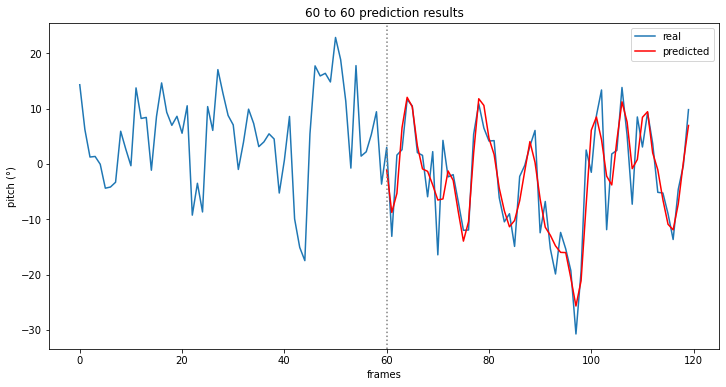

In [39]:
frames = np.arange(0, FRAMES_IN+FRAMES_OUT)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(frames, torch.cat((input_sequence[0].apply_(denorm_pr), output_sequence[0].apply_(denorm_pr))), label="real")
ax.plot(frames[FRAMES_IN:], predicted_sequence[0].apply_(denorm_pr), color="red", label='predicted')
plt.axvline(x=FRAMES_IN, color='grey', linestyle='dotted')
ax.set_xlabel('frames')
ax.set_ylabel('pitch (°)')
ax.set_title(f'{FRAMES_IN} to {FRAMES_OUT} prediction results')
plt.legend()
# plt.savefig(f'{RESULT_FOLDER}/1ep_pitch-prediction_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

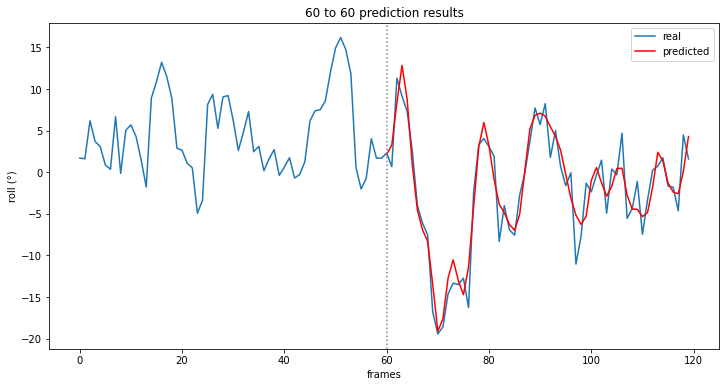

In [40]:
frames = np.arange(0, FRAMES_IN+FRAMES_OUT)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(frames, torch.cat((input_sequence[1].apply_(denorm_pr), output_sequence[1].apply_(denorm_pr))), label="real")
ax.plot(frames[FRAMES_IN:], predicted_sequence[1].apply_(denorm_pr), color="red", label='predicted')
plt.axvline(x=FRAMES_IN, color='grey', linestyle='dotted')
ax.set_xlabel('frames')
ax.set_ylabel('roll (°)')
ax.set_title(f'{FRAMES_IN} to {FRAMES_OUT} prediction results')
plt.legend()
# plt.savefig(f'{RESULT_FOLDER}/1ep_roll-prediction_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

### Inference time

In [32]:
current = os.path.dirname(os.path.realpath(''))
parent = os.path.dirname(current)
sys.path.append(parent)  

In [34]:
# del sys.modules["notebooks.data_loaders.utils"]
from notebooks.data_loaders.utils import Utilities

total, inference = Utilities.inference_time(loaded_model, x_test, repetitions=10000)
print(f"total execution time for 10.000 predictions: {np.sum(total)}")
print(f"Inference time for 10.000 predictions:\t {inference}")

sum = 0
for p in loaded_model.parameters():
    sum += p.numel()

print(f"Total trainable parameters:\t {sum}")

total execution time for 10.000 predictions: 1551.7994148656726
Inference time for 10.000 predictions:	 0.15517994148656725
Total trainable parameters:	 1211010


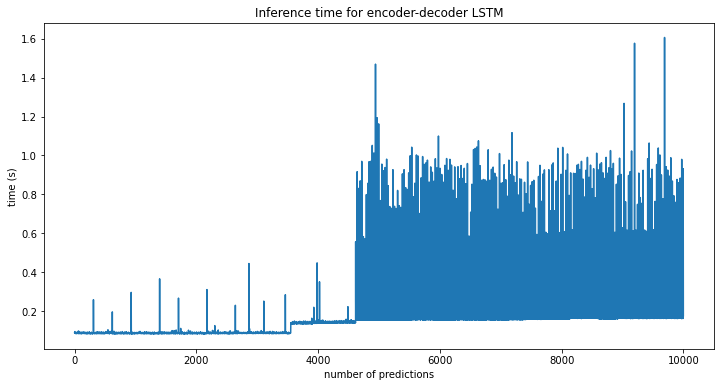

In [37]:
plt.figure(figsize=(12,6))
plt.plot(total)
plt.ylabel("time (s)")
plt.xlabel("number of predictions")
plt.title("Inference time for encoder-decoder LSTM")
plt.savefig(f'{RESULT_FOLDER}/inference_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}',  bbox_inches='tight')
plt.show()

### Full test loop

In [53]:
predictions = []
labels = []

with torch.no_grad():
    for batch in tqdm(data_module.test_dataloader()):
        x_test = batch["sequence"]
        y_test = batch["labels"]

        if CUDA:
            x_test = x_test.cuda()

        output = loaded_model(x_test)

        # squeeze out batch size which is = 1 for test dataset
        predictions.append(output.cpu().squeeze(0))
        labels.append(y_test.squeeze(0))

  0%|          | 0/30348 [00:00<?, ?it/s]

In [54]:
# Predictions[0] = tensor object
# Predictions[0][0] = pitch sequence
# Predictions[0][1] = roll sequence

pitch_predictions = []
roll_predictions = []

pitch_label = []
roll_label = []

for i in range(len(predictions)):
    pitch_predictions.append(predictions[i][0])
    roll_predictions.append(predictions[i][1])
    pitch_label.append(labels[i][0])
    roll_label.append(labels[i][1])

pitch_predictions[0].shape, roll_predictions[0].shape, pitch_label[0].shape, roll_label[0].shape

(torch.Size([60]), torch.Size([60]), torch.Size([60]), torch.Size([60]))

### Average loss-per-frame over all datapoints

In [55]:
# function that returns a list with loss-values per frame
def loss_per_frame(predicted_sequence, real_sequence):
    loss_per_frame = []
    criterion = nn.MSELoss()
    if predicted_sequence.shape != real_sequence.shape:
        return loss_per_frame
    for i in range(len(predicted_sequence)):
        loss = criterion(predicted_sequence[i], real_sequence[i])
        loss_per_frame.append(loss.item())
    return loss_per_frame

In [56]:
# calculate mean loss per frame over all test data
total = len(pitch_predictions)
pitch_total = np.zeros(FRAMES_OUT, dtype=np.float64)
roll_total = np.zeros(FRAMES_OUT, dtype=np.float64)

for i in tqdm(range(len(pitch_predictions))):
    pitch_lpf = loss_per_frame(pitch_predictions[i], pitch_label[i])
    roll_lpf = loss_per_frame(roll_predictions[i], roll_label[i])
    pitch_total += pitch_lpf
    roll_total += roll_lpf

pitch_lpf_mse = pitch_total / total
roll_lpf_mse = roll_total / total

  0%|          | 0/30348 [00:00<?, ?it/s]

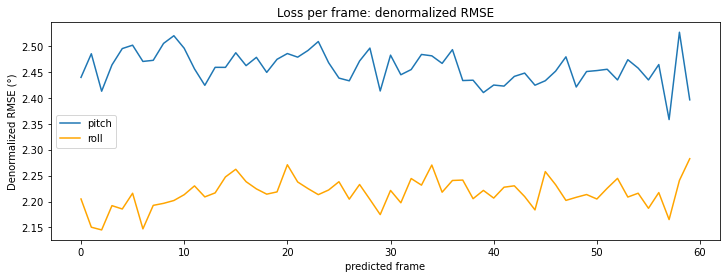

In [57]:
pitch_lpf_rmse = np.sqrt(pitch_lpf_mse)
roll_lpf_rmse = np.sqrt(roll_lpf_mse)
denorm = lambda x: denorm_pr(x)
vfunc = np.vectorize(denorm)
plt.figure(figsize=(12, 4))
plt.plot(vfunc(pitch_lpf_rmse), label='pitch')
plt.plot(vfunc(roll_lpf_rmse), color='orange', label='roll')
plt.xlabel('predicted frame')
plt.ylabel('Denormalized RMSE (°)')
plt.title('Loss per frame: denormalized RMSE')
plt.legend()
if SAVE_RESULTS:
    plt.savefig(f'{RESULT_FOLDER}/LPF-denorm-RMSE_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')
plt.show()

### MSE results pitch

In [81]:
n = len(pitch_predictions)
loss0_tensor = torch.zeros(FRAMES_OUT)
criterion = nn.MSELoss()

loss = []
loss0 = []

total = 0
total0 = 0

for i in range(n):
    error = criterion(pitch_label[i], pitch_predictions[i]).item()
    error0 = criterion(pitch_label[i], loss0_tensor).item()
    loss.append(denorm_pr(math.sqrt(error)))
    loss0.append(denorm_pr(math.sqrt(error)))
    total += error
    total0 += error0
    

mse = round(total/n, 5)
rmse = round(math.sqrt(total/n), 4)
mse0 = round(total0/n, 5)
rmse0 = round(math.sqrt(total0/n), 4)

np.save(f"{TEST_RESULT_FOLDER}/pitch_denormalized_error", loss)
np.save(f"{TEST_RESULT_FOLDER}/pitch_zero_error", loss0)

print("Pitch prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print(f"   RMSE denorm: {round(denorm_pr(rmse), 2)}°")
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print(f"   RMSE denorm: {round(denorm_pr(rmse0), 2)}°")
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

Pitch prediction
   MSE: 0.00075
   RMSE: 0.0273
   RMSE denorm: 2.46°
Zero prediction
   MSE 0: 0.00449
   RMSE 0: 0.067
   RMSE denorm: 6.03°
Improvement on zero prediction:
   MSE delta%: 598.67 %
   RMSE delta%: 245.42 %


### MSE results roll

In [82]:
n = len(pitch_predictions)
loss0_tensor = torch.zeros(FRAMES_OUT)
criterion = nn.MSELoss()

loss = []
loss0 = []

total = 0
total0 = 0

for i in range(n):
    error = criterion(roll_label[i], roll_predictions[i]).item()
    error0 = criterion(roll_label[i], loss0_tensor).item()
    loss.append(denorm_pr(math.sqrt(error)))
    loss0.append(denorm_pr(math.sqrt(error)))
    total += error
    total0 += error0
    

mse = round(total/n, 5)
rmse = round(math.sqrt(total/n), 4)
mse0 = round(total0/n, 5)
rmse0 = round(math.sqrt(total0/n), 4)

np.save(f"{TEST_RESULT_FOLDER}/roll_denormalized_error", loss)
np.save(f"{TEST_RESULT_FOLDER}/roll_zero_error", loss0)

print("Roll prediction")
print("   MSE:", mse)
print("   RMSE:", rmse)
print(f"   RMSE denorm: {round(denorm_pr(rmse), 2)}°")
print("Zero prediction")
print("   MSE 0:", mse0)
print("   RMSE 0:", rmse0)
print(f"   RMSE denorm: {round(denorm_pr(rmse0), 2)}°")
print("Improvement on zero prediction:")
print("   MSE delta%:", round(mse0/mse*100, 2), "%")
print("   RMSE delta%:", round(rmse0/rmse*100, 2), "%")

Roll prediction
   MSE: 0.00061
   RMSE: 0.0246
   RMSE denorm: 2.21°
Zero prediction
   MSE 0: 0.00716
   RMSE 0: 0.0846
   RMSE denorm: 7.61°
Improvement on zero prediction:
   MSE delta%: 1173.77 %
   RMSE delta%: 343.9 %


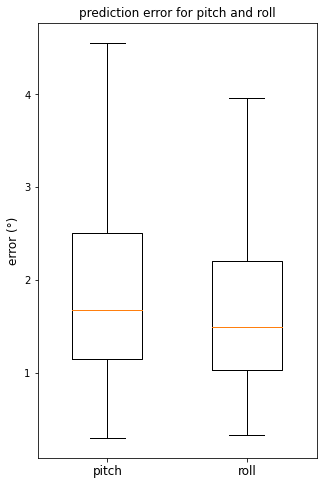

In [111]:
fig, ax = plt.subplots(figsize=(5,8))
pitch_error = np.load(f"{TEST_RESULT_FOLDER}/pitch_denormalized_error.npy")
roll_error = np.load(f"{TEST_RESULT_FOLDER}/roll_denormalized_error.npy")
ax.boxplot([pitch_error, roll_error], showfliers=False, widths=(0.5))
ax.set_ylabel("error (°)", fontsize=12)
ax.set_xticks([1,2], ["pitch", "roll"], fontsize=12)
ax.set_title("prediction error for pitch and roll", fontsize=12)
if SAVE_RESULTS:
    plt.savefig(f'{RESULT_FOLDER}/error_boxplot_{FRAMES_IN}in_{FRAMES_OUT}out_epochs{NUM_EPOCHS}')